## Question C
Increase the number of neurons.  Plot the test error of the best trained linear models with increasing number of neurons.  You can experiment with different network sizes.  Plot the test error with respect to the neurons.


In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec
from tensorflow.examples.tutorials.mnist import input_data
%matplotlib inline

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Reset the graph
tf.reset_default_graph()

# Constants
numPixels = 784
firstLayerOutput = 10
numClassifications = 10
rate = 0.2
epochs = 2000
iterationsPerEpoch = 10
numIterations = 10

# Initialize values to graph later or use for later calculations
numNeurons = []
testErrors = []

# Perform the neural net calculation 20 times with an increasing number of neurons from the hidden layer
for i in range(1, numIterations + 1):
    # Reset the graph
    tf.reset_default_graph()
    
    # Shape = (N x 784). N images of size 28 pixels by 28 pixels
    x = tf.placeholder(tf.float32, [None, numPixels])
    # Shape = (N x 10). N images with one hot values indicating if it's 0-9
    ref = tf.placeholder(tf.float32, [None, numClassifications])
    # Shape = (N x (10 * (i*2))). The hidden layer outputs (10*(i*2)) neurons which are fed to the output layer
    logits1 = tf.layers.dense(inputs=x, units=firstLayerOutput * (i*2), activation=tf.nn.relu, name="L1")
    # Shape = (N x 10). The logit values of the likelihood that each image is 0-9.
    logits2 = tf.layers.dense(inputs=logits1, units=numClassifications, activation=tf.nn.relu, name="L2")
    
    # Convert the logit values into a probability from 0-1 (indicating confidence percentage) for each classification from 0-9
    probability = tf.nn.softmax(logits2)
    # Shape = (N). Take the highest percentile value in the prediction as the neural network's guess
    prediction = tf.argmax((probability), axis=1)

    # Calculate the cross entropy, doing the softmax function internally
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits2, labels=ref)
    # Take the average of the cross entropy values to determine the overall cost function
    cost = tf.reduce_mean(cross_entropy)

    # Take the largest 1 hot value for each image's label to get the classification of each image
    labels = []
    for label in mnist.test.labels:
        labels.append(np.argmax(label))
    # Shape = (N). Convert the list into a numpy array for later comparisons
    labels = np.array(labels)
    
    # Initialize the optimizer
    optimizer = tf.train.GradientDescentOptimizer(rate).minimize(cost)
    s = tf.Session()
    s.run(tf.global_variables_initializer())

    # Run the training on 2000 different image sets of size 100 
    for _ in range(epochs):
        inputData, correctAns = mnist.train.next_batch(100)
        validationInput, validationCorrect = mnist.train.next_batch(100)
        # Run the training on the image set of size 100, 10 times
        for _ in range(iterationsPerEpoch):
            # Do the training
            err, _ = s.run((cost, optimizer), feed_dict={x: inputData, ref: correctAns})

    # Get the highest percentile probability value for each image
    predic = s.run((prediction), feed_dict={x: mnist.test.images})
    # Check if the highest percentile is the same as the correct answer
    answers = np.equal(labels, predic)
    # Sum the number of correct answers and determine the error
    corrGuesses = np.sum(answers)
    testErr = corrGuesses / len(answers)   
    
    # Add the values to be tracked into their respective lists
    numNeurons.append(firstLayerOutput * (i*2))
    testErrors.append((1 - testErr) * 100)
    s.close()
    
    # Print indicator to show that the it is not frozen
    print(str((i / numIterations)*100) + "% Complete: The test error for this iteration is " + str((1-testErr)*100) + "%.")

10.0% Complete: The test error for this iteration is 5.18%.
20.0% Complete: The test error for this iteration is 3.37%.
30.0% Complete: The test error for this iteration is 3.17%.
40.0% Complete: The test error for this iteration is 3.01%.
50.0% Complete: The test error for this iteration is 2.91%.
60.0% Complete: The test error for this iteration is 12.21%.
70.0% Complete: The test error for this iteration is 13.98%.
80.0% Complete: The test error for this iteration is 2.62%.
90.0% Complete: The test error for this iteration is 2.46%.
100.0% Complete: The test error for this iteration is 2.33%.


It would appear that generally as the number of neurons increases, the test error decreases. As the number of neurons continues to increase, the improvement on the test error becomes less and less significant until it evens out at around 2-3.5% test error. However, there is sometimes a large spike in the graph where the test error increases quite significantly. I believe the reason behind this would be that the next_batch returns 100 random images, if these sets of 100 images intersect quite a few times over the 2000 sets during training then there would be overfitting on those images. Which in turn would throw off the test error since the overfitting would cause a problems on untrained images.

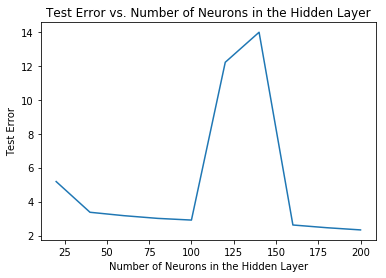

In [3]:
plt.plot(numNeurons, testErrors)
plt.ylabel('Test Error')
plt.xlabel('Number of Neurons in the Hidden Layer')
plt.title('Test Error vs. Number of Neurons in the Hidden Layer')
plt.show()

### Please Note:
I used the rectified linear activation function rather than purely linear activation for each layer since the test error was not improving much (and was stagnating at around 10%). I believe the above graph is more meaningful for what the question is asking and technically they're both linear activation functions. I believe this is due to very large negative weights influencing the other neurons inside of the hidden layer. The rectified linear activation will take any values less than 0 and set them as 0, which will minimize the effect of overfitting.
<br> 
<br> If you wish to see the linear output, change the below lines from...
<br> logits1 = tf.layers.dense(inputs=x, units=firstLayerOutput * (i * 2), activation=tf.nn.relu, name="L1")
<br> logits2 = tf.layers.dense(inputs=logits1, units=numClassifications, activation=tf.nn.relu, name="L2")
<br> to...
<br> logits1 = tf.layers.dense(inputs=x, units=firstLayerOutput * (i * 2), activation=None, name="L1")
<br> logits2 = tf.layers.dense(inputs=logits1, units=numClassifications, activation=None, name="L2")